## Outline:

    1. Preliminary Data Analysis
    2. Exploratory Data Analysis
    3. Data Transformations
    4. Model Development & Classification
    5. Model Evaluation
    6. Conclusion 

In [1]:
#importing necessary libraries
import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import metrics

def printmd(string):
    display(Markdown(string))
    
    
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


%matplotlib inline

In [2]:
#importing the raw data files as well as with cross validation performed 
adult = pd.read_csv('adult.csv')
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num','marital-status', 'occupation', 'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']

train = pd.read_csv('adult_data.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test = pd.read_csv('adult_test.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test['income'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')

adult = pd.concat([test,train])
adult.reset_index(inplace = True, drop = True)

---
# 1. Preliminary Data Analysis

In [3]:
# Setting all the categorical columns to type category 
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')
    
printmd('## 1.1 Columns and their types')
print(adult.info())

## 1.1 Columns and their types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null category
fnlwgt             48842 non-null int64
education          48842 non-null category
educational-num    48842 non-null int64
marital-status     48842 non-null category
occupation         48842 non-null category
relationship       48842 non-null category
race               48842 non-null category
gender             48842 non-null category
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null category
income             48842 non-null category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None


In [4]:
adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
printmd('## 1.2 Summary Statistics')
adult.describe()

## 1.2 Summary Statistics

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
# Checking for missing values
printmd('## 1.3 Missing values')
for i,j in zip(adult.columns,(adult.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        printmd(str(i) + ': ' + str(j) + ' records')



## 1.3 Missing values

workclass: 2799 records

occupation: 2809 records

native-country: 857 records

### Replacing missing values with appropriate ones

I fill the missing values in each of the three columns by predicting their values. For each of the three columns, I use all the attributes (including 'income') as independent variables and treat that column as the dependent variable, making it a multi-class classification task. I use three classification algorithms, namely, logistic regression, decision trees and random forest to predict the class when the value is missing ('?'). I then take a majority vote amongst the three classifiers to be the class of the missing value. In case of a tie, I pick the majority class of that column using the entire dataset.

In [7]:
# Create one hot encoding of the categorical columns in the data frame.
def oneHotCatVars(df, df_cols):
    
    df_1 = adult_data = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))

In [8]:
printmd('## 1.4 Filling in missing values for Attribute workclass')

test_data = adult[(adult.workclass.values == '?')].copy()
test_label = test_data.workclass

train_data = adult[(adult.workclass.values != '?')].copy()
train_label = train_data.workclass

test_data.drop(columns = ['workclass'], inplace = True)
train_data.drop(columns = ['workclass'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = adult.workclass.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.workclass.values == '?'),'workclass'] = overall_pred.values
print(adult.workclass.value_counts())
print(adult.workclass.unique())

## 1.4 Filling in missing values for Attribute workclass

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Private             36346
Self-emp-not-inc     3872
Local-gov            3138
State-gov            1983
Self-emp-inc         1696
Federal-gov          1432
Never-worked          354
Without-pay            21
?                       0
Name: workclass, dtype: int64
[Private, Local-gov, Self-emp-not-inc, Federal-gov, State-gov, Self-emp-inc, Never-worked, Without-pay]
Categories (8, object): [Private, Local-gov, Self-emp-not-inc, Federal-gov, State-gov, Self-emp-inc, Never-worked, Without-pay]


In [9]:
printmd('## 1.5 Filling in missing values for Occupation occupation')

test_data = adult[(adult.occupation.values == '?')].copy()
test_label = test_data.occupation

train_data = adult[(adult.occupation.values != '?')].copy()
train_label = train_data.occupation

test_data.drop(columns = ['occupation'], inplace = True)
train_data.drop(columns = ['occupation'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult.occupation.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.occupation.values == '?'),'occupation'] = overall_pred.values
print(adult.occupation.value_counts())
print(adult.occupation.unique())

## 1.5 Filling in missing values for Occupation occupation

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Prof-specialty       7761
Craft-repair         6398
Exec-managerial      6173
Adm-clerical         5870
Sales                5637
Other-service        5194
Machine-op-inspct    3077
Transport-moving     2398
Handlers-cleaners    2109
Farming-fishing      1501
Tech-support         1465
Protective-serv       990
Priv-house-serv       254
Armed-Forces           15
?                       0
Name: occupation, dtype: int64
[Machine-op-inspct, Farming-fishing, Protective-serv, Prof-specialty, Other-service, ..., Tech-support, Sales, Priv-house-serv, Transport-moving, Armed-Forces]
Length: 14
Categories (14, object): [Machine-op-inspct, Farming-fishing, Protective-serv, Prof-specialty, ..., Sales, Priv-house-serv, Transport-moving, Armed-Forces]


In [10]:
printmd('## 1.6 Filling in missing values for Native Country')

test_data = adult[(adult['native-country'].values == '?')].copy()
test_label = test_data['native-country']

train_data = adult[(adult['native-country'].values != '?')].copy()
train_label = train_data['native-country']

test_data.drop(columns = ['native-country'], inplace = True)
train_data.drop(columns = ['native-country'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult['native-country'].value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult['native-country'].values == '?'),'native-country'] = overall_pred.values
print(adult['native-country'].value_counts())
print(adult['native-country'].unique())

## 1.6 Filling in missing values for Native Country

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


United-States                 44638
Mexico                          964
Philippines                     305
Germany                         206
Puerto-Rico                     184
Canada                          182
India                           156
El-Salvador                     155
Cuba                            138
China                           127
England                         127
South                           121
Jamaica                         107
Italy                           105
Dominican-Republic              104
Japan                            95
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Taiwan                           67
Portugal                         67
Iran                             59
Nicaragua                        49
Greece                           49
Peru                             46
Ecuador                     

In [11]:
# Resetting the categories
adult['workclass'] = adult['workclass'].cat.remove_categories('?')
adult['occupation'] = adult['occupation'].cat.remove_categories('?')
adult['native-country'] = adult['native-country'].cat.remove_categories('?')

In [12]:
printmd ('## 1.7 Correlation Matrix')
display(adult.corr())

## 1.7 Correlation Matrix

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519
educational-num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689
capital-gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157
capital-loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467
hours-per-week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000


We see that none of the columns are highly correlated.

---
# 2. Exploratory Data Analysis

In [13]:
# Creating a dictionary that contain the education and it's corresponding education level
edu_level = {}
for x,y in adult[['educational-num','education']].drop_duplicates().itertuples(index=False):
    edu_level[y] = x

## 2.1 Education vs Income

I plot a bar graph showing the proportion of income classes across education levels         in the figure below. As one would expect, we see from the bar graph below that as the         education level increase, the proportion of people who earn more than 50k a year also         increase. It is interesting to note that only after a master's degree, the proportion of         people earning more than 50k a year, is a majority.

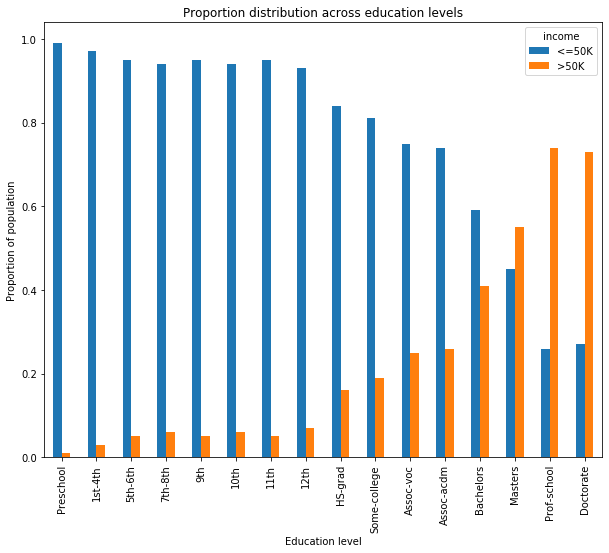

In [14]:
printmd('## 2.1 Education vs Income')

education = round(pd.crosstab(adult.education, adult.income).div(pd.crosstab(adult.education, adult.income).apply(sum,1),0),2)
education = education.reindex(sorted(edu_level, key=edu_level.get, reverse=False))

ax = education.plot(kind ='bar', title = 'Proportion distribution across education levels', figsize = (10,8))
ax.set_xlabel('Education level')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across education levels \
        in the figure below. As one would expect, we see from the bar graph below that as the \
        education level increase, the proportion of people who earn more than 50k a year also \
        increase. It is interesting to note that only after a master\'s degree, the proportion of \
        people earning more than 50k a year, is a majority.')
        

## 2.2 Gender vs Income

We plot a bar graph showing the proportion of income classes across the genders in figure         below. From the graph, at an overall view, there exists a wage gap between females and males.         Since we do not have the exactly value of the income, we are limited to only observing that the         proportion of males earning more than 50k a year is more than double of their female counterparts.         

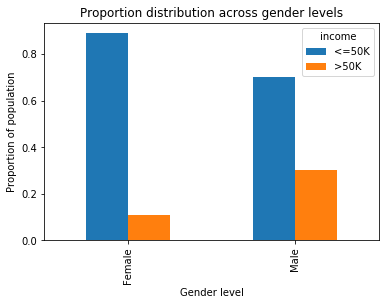

In [15]:
printmd('## 2.2 Gender vs Income')

gender = round(pd.crosstab(adult.gender, adult.income).div(pd.crosstab(adult.gender, adult.income).apply(sum,1),0),2)
gender.sort_values(by = '>50K', inplace = True)
ax = gender.plot(kind ='bar', title = 'Proportion distribution across gender levels')
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('We plot a bar graph showing the proportion of income classes across the genders in figure \
        below. From the graph, at an overall view, there exists a wage gap between females and males. \
        Since we do not have the exactly value of the income, we are limited to only observing that the \
        proportion of males earning more than 50k a year is more than double of their female counterparts. \
        ')

Taking a closer look at the disparity in income between men and women, plot the         proportion of men and women who earn more than 50k a year, across all the working         classes as seen in Fig. 3. We see that men always have a higher proportion earning         more than 50k a year than women, except for the 'without.pay' working class, where         they have the same proportion.

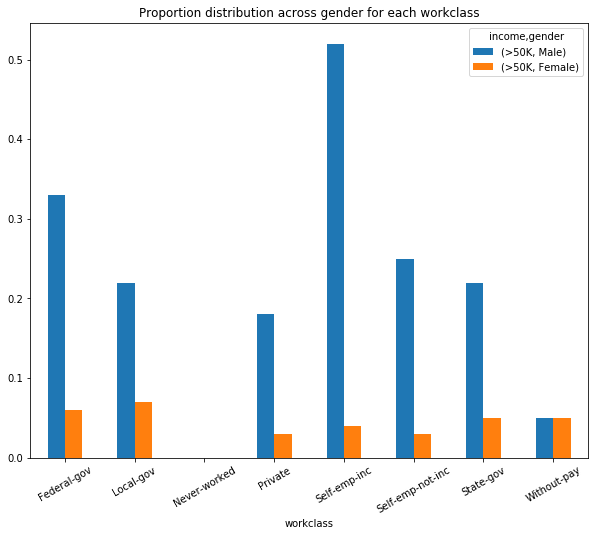

In [16]:
gender_workclass = round(pd.crosstab(adult.workclass, [adult.income, adult.gender]).div(pd.crosstab(adult.workclass, [adult.income, adult.gender]).apply(sum,1),0),2)
gender_workclass[[('>50K','Male'), ('>50K','Female')]].plot(kind = 'bar', title = 'Proportion distribution across gender for each workclass', figsize = (10,8), rot = 30)
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('Taking a closer look at the disparity in income between men and women, plot the \
        proportion of men and women who earn more than 50k a year, across all the working \
        classes as seen in Fig. 3. We see that men always have a higher proportion earning \
        more than 50k a year than women, except for the \'without.pay\' working class, where \
        they have the same proportion.')

### Gender across working classes

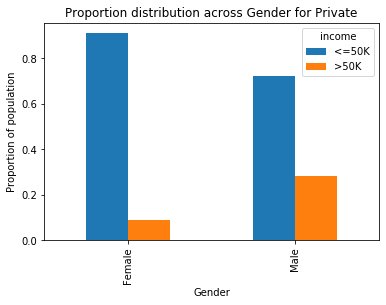

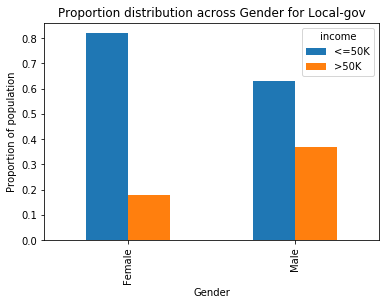

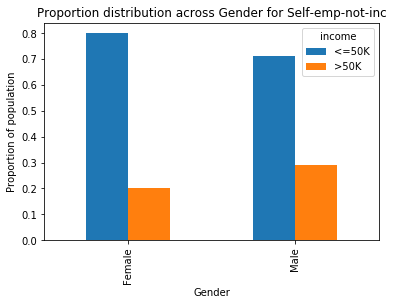

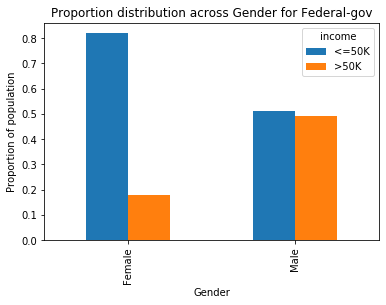

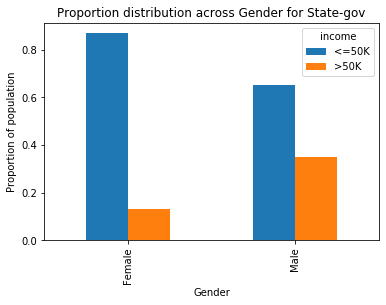

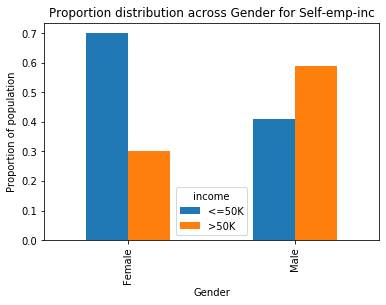

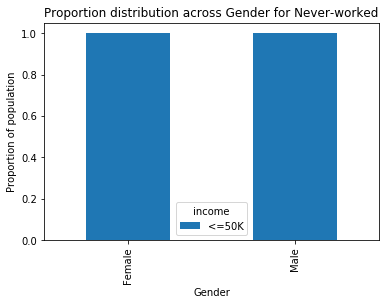

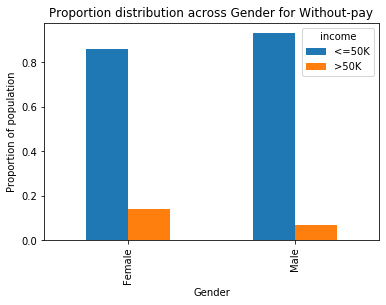

In [17]:
printmd('### Gender across working classes')

for i in adult.workclass.unique():
    df = adult[adult.workclass == i]
    hours_per_week = round(pd.crosstab(df.gender, df.income).div(pd.crosstab(df.gender, df.income).apply(sum,1),0),2)
    #hours_per_week.sort_values(by = '>50K', inplace = True)
    ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Gender for '+ i)
    ax.set_xlabel('Gender')
    ax.set_ylabel('Proportion of population')
    print()

## 2.3. Occupation vs Income

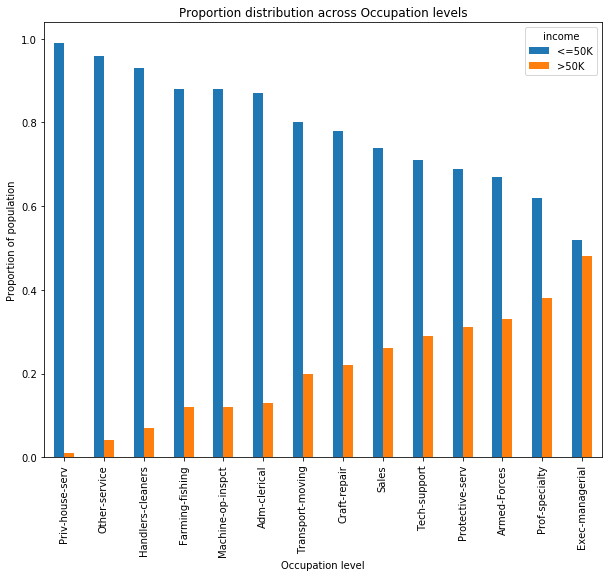

In [18]:
printmd('## 2.3. Occupation vs Income')

occupation = round(pd.crosstab(adult.occupation, adult.income).div(pd.crosstab(adult.occupation, adult.income).apply(sum,1),0),2)
occupation.sort_values(by = '>50K', inplace = True)
ax = occupation.plot(kind ='bar', title = 'Proportion distribution across Occupation levels', figsize = (10,8))
ax.set_xlabel('Occupation level')
ax.set_ylabel('Proportion of population')

print()

## 2.4. Workclass vs Income

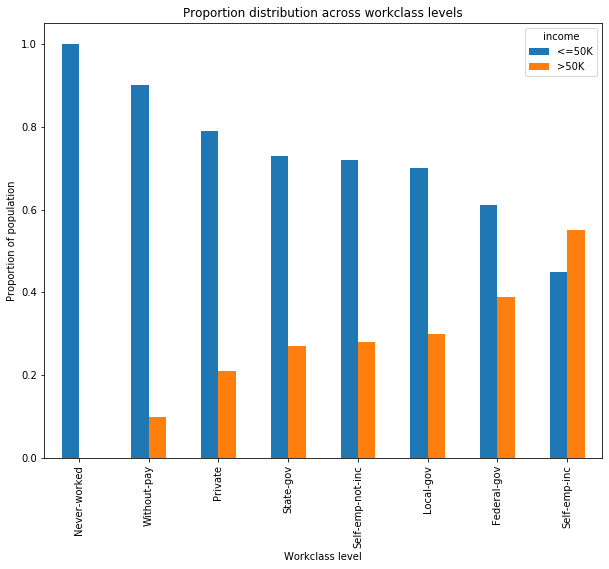

In [19]:
printmd('## 2.4. Workclass vs Income')

workclass = round(pd.crosstab(adult.workclass, adult.income).div(pd.crosstab(adult.workclass, adult.income).apply(sum,1),0),2)
workclass.sort_values(by = '>50K', inplace = True)
ax = workclass.plot(kind ='bar', title = 'Proportion distribution across workclass levels', figsize = (10,8))
ax.set_xlabel('Workclass level')
ax.set_ylabel('Proportion of population')

print()

## 2.5. Race vs Income

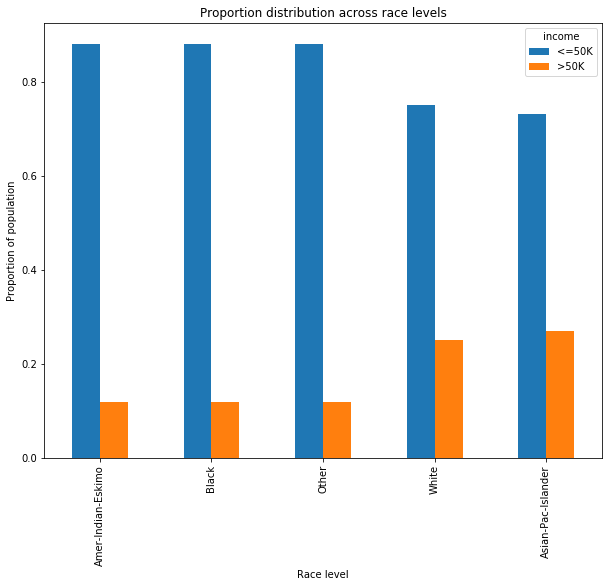

In [20]:
printmd('## 2.5. Race vs Income')

race = round(pd.crosstab(adult.race, adult.income).div(pd.crosstab(adult.race, adult.income).apply(sum,1),0),2)
race.sort_values(by = '>50K', inplace = True)
ax = race.plot(kind ='bar', title = 'Proportion distribution across race levels', figsize = (10,8))
ax.set_xlabel('Race level')
ax.set_ylabel('Proportion of population')

print()

## 2.6. Native Country

I plot a bar graph showing the proportion of income classes across the native country in figure         below. From the graph, we notice a trend in positioning of the country. South American country are         at the left end of the plot, with low proportion of population that make more than 50k a year. The         United States is located somewhat centrally, and at the right are countries from Europe and Asia,         with higher proportion of population that make more than 50k a year.

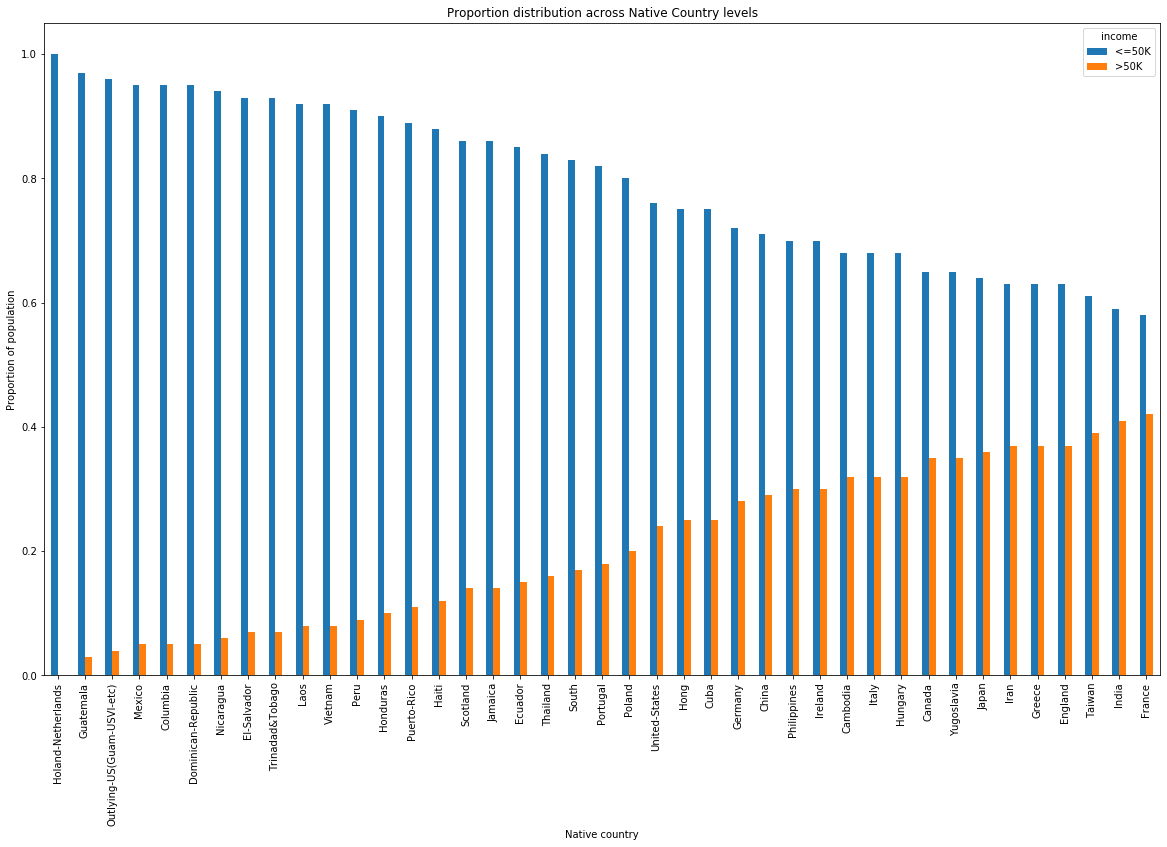

In [21]:
printmd('## 2.6. Native Country')

native_country = round(pd.crosstab(adult['native-country'], adult.income).div(pd.crosstab(adult['native-country'], adult.income).apply(sum,1),0),2)
native_country.sort_values(by = '>50K', inplace = True)
ax = native_country.plot(kind ='bar', title = 'Proportion distribution across Native Country levels', figsize = (20,12))
ax.set_xlabel('Native country')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the native country in figure \
        below. From the graph, we notice a trend in positioning of the country. South American country are \
        at the left end of the plot, with low proportion of population that make more than 50k a year. The \
        United States is located somewhat centrally, and at the right are countries from Europe and Asia, \
        with higher proportion of population that make more than 50k a year.')


## 2.7. Hours per week vs Income

I plot a bar graph showing the proportion of income classes across the hours worked.         We would expected to notice a trend that higher the hours worked per week, the higher the proportion         of population making more than 50k a year. However, this was not necessarily true from the graph.         For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on)         no one earned more than 50k a year. 

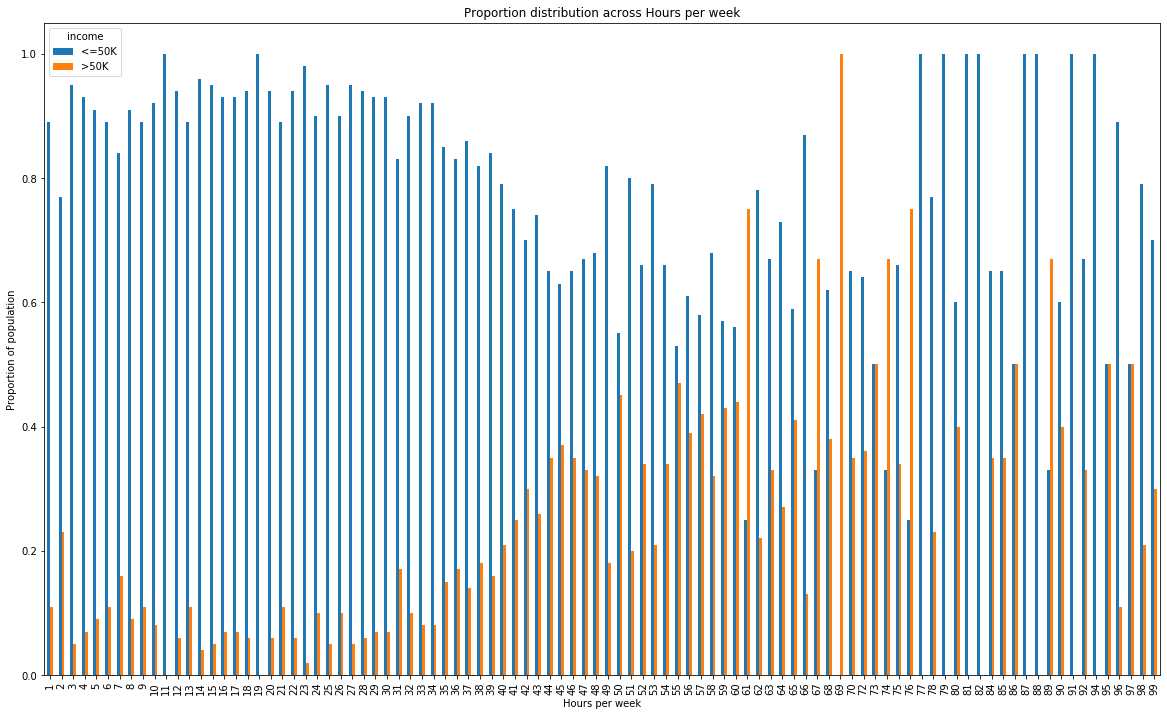

In [22]:
printmd('## 2.7. Hours per week vs Income')

hours_per_week = round(pd.crosstab(adult['hours-per-week'], adult.income).div(pd.crosstab(adult['hours-per-week'], adult.income).apply(sum,1),0),2)
# hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (20,12))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the hours worked. \
        We would expected to notice a trend that higher the hours worked per week, the higher the proportion \
        of population making more than 50k a year. However, this was not necessarily true from the graph. \
        For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on) \
        no one earned more than 50k a year. ')


### 2.7.1 Hours per week with categories

Therefore, I decided to transform this column into 3 categories, less than 40 hours,         40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories,         we can see from the figure below that there is an increasing trend in the proportion of         population making more than 50k a year.

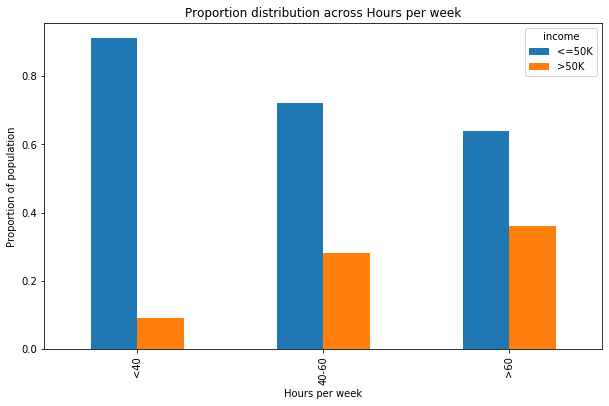

In [23]:
printmd('### 2.7.1 Hours per week with categories')

adult['hour_worked_bins'] = ['<40' if i < 40 else '40-60' if i <= 60 else '>60'  for i in adult['hours-per-week']]
adult['hour_worked_bins'] = adult['hour_worked_bins'].astype('category')
hours_per_week = round(pd.crosstab(adult.hour_worked_bins, adult.income).div(pd.crosstab(adult.hour_worked_bins, adult.income).apply(sum,1),0),2)

hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (10,6))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('Therefore, I decided to transform this column into 3 categories, less than 40 hours, \
        40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories, \
        we can see from the figure below that there is an increasing trend in the proportion of \
        population making more than 50k a year.')


### 2.7.2 Hours worked across working classes

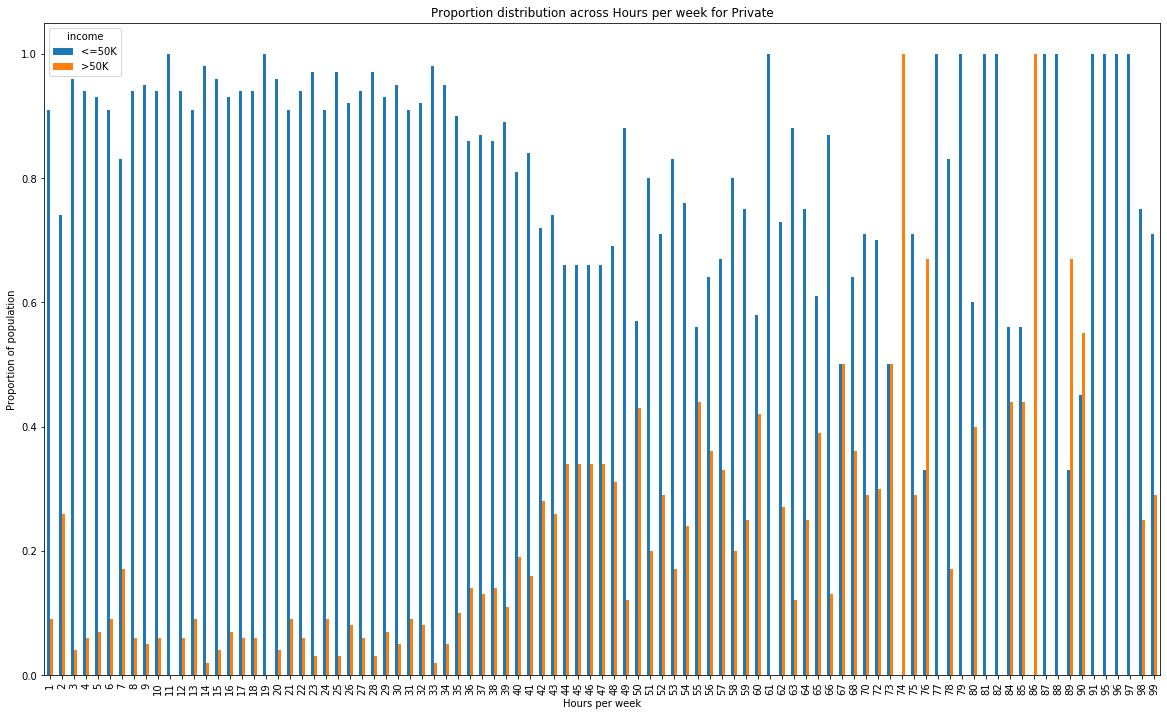

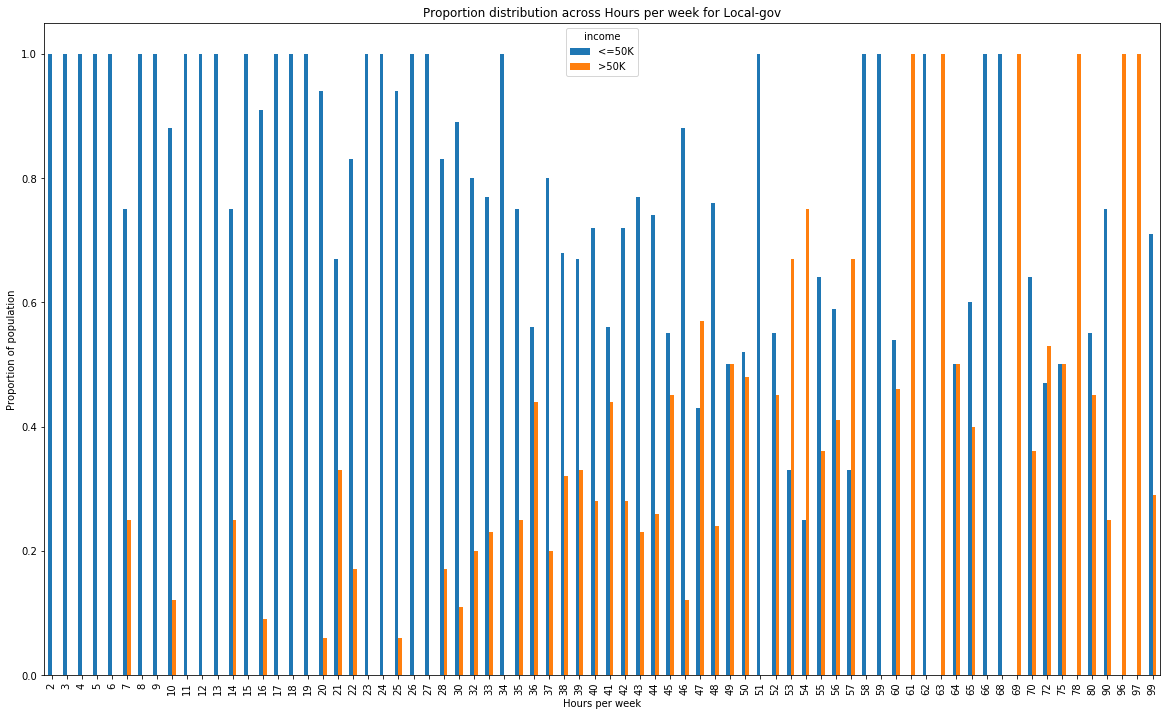

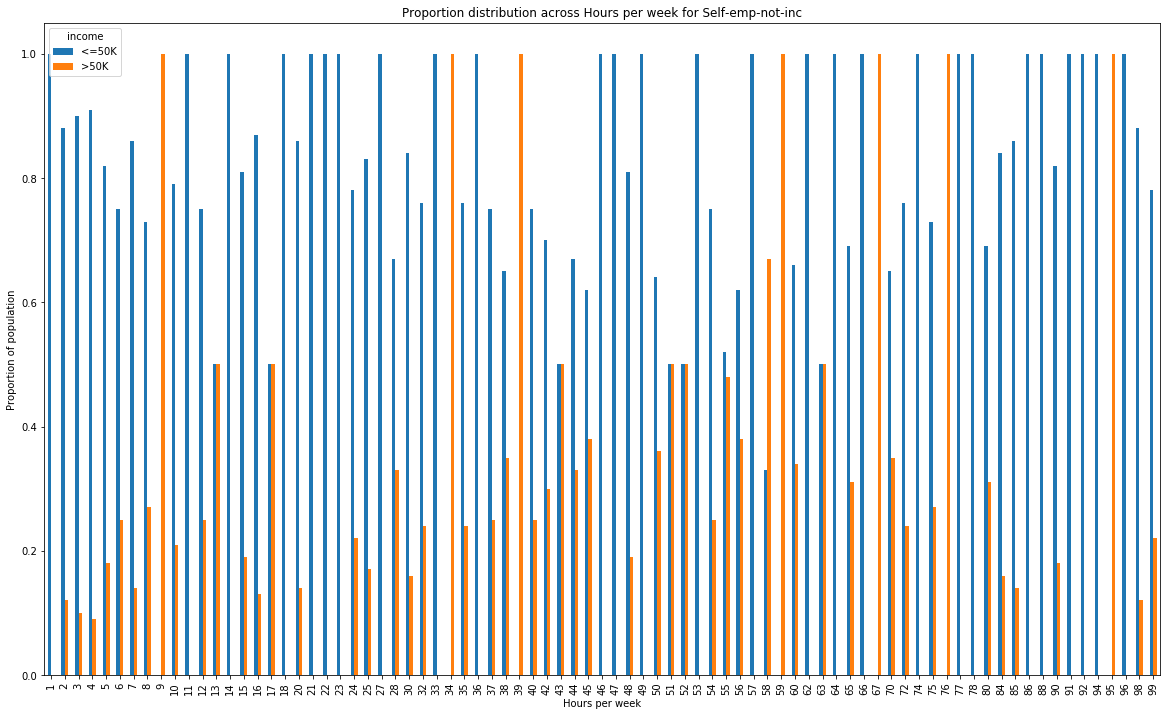

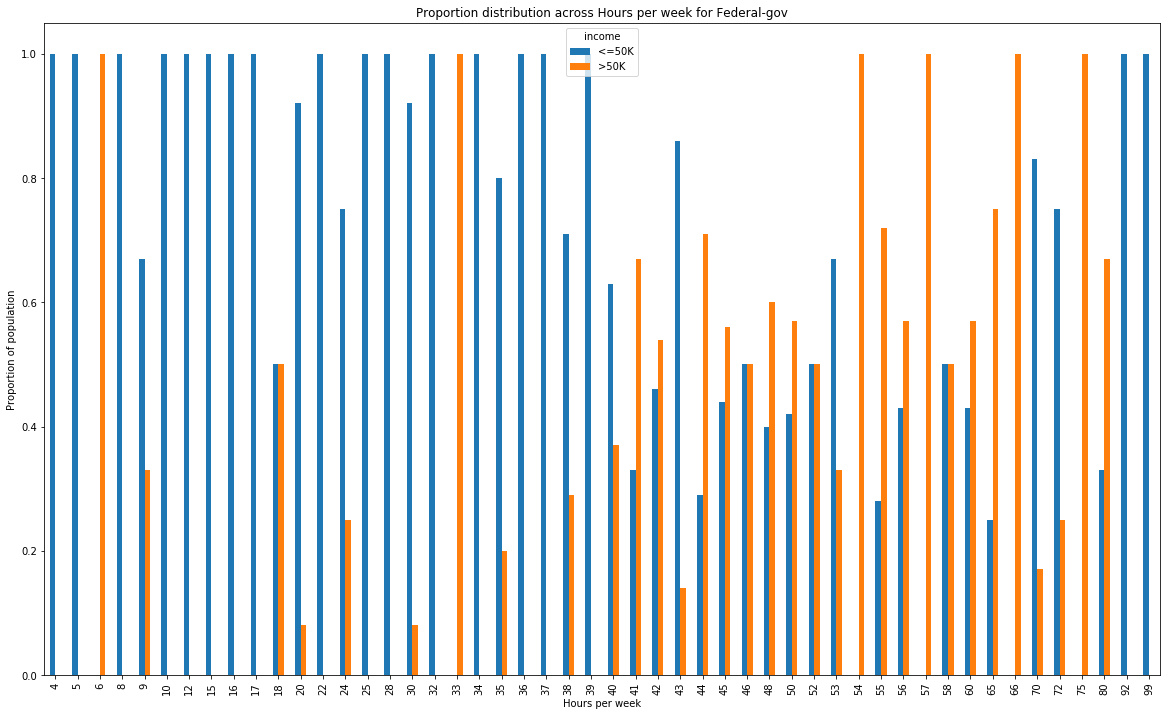

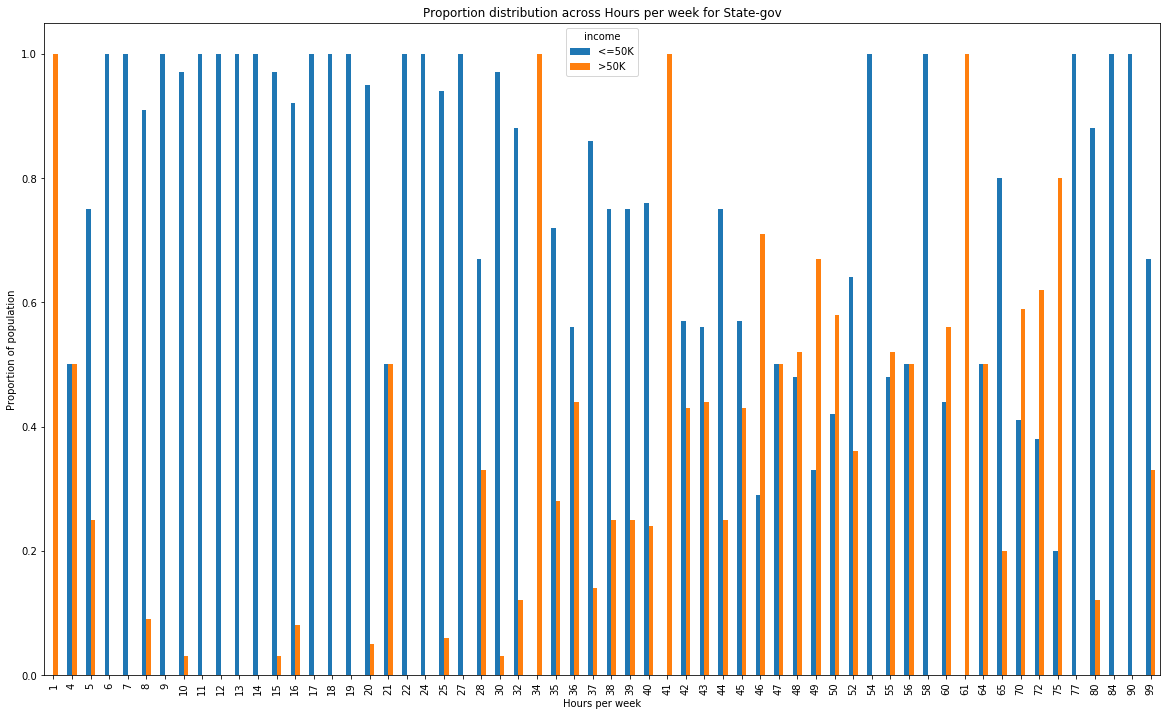

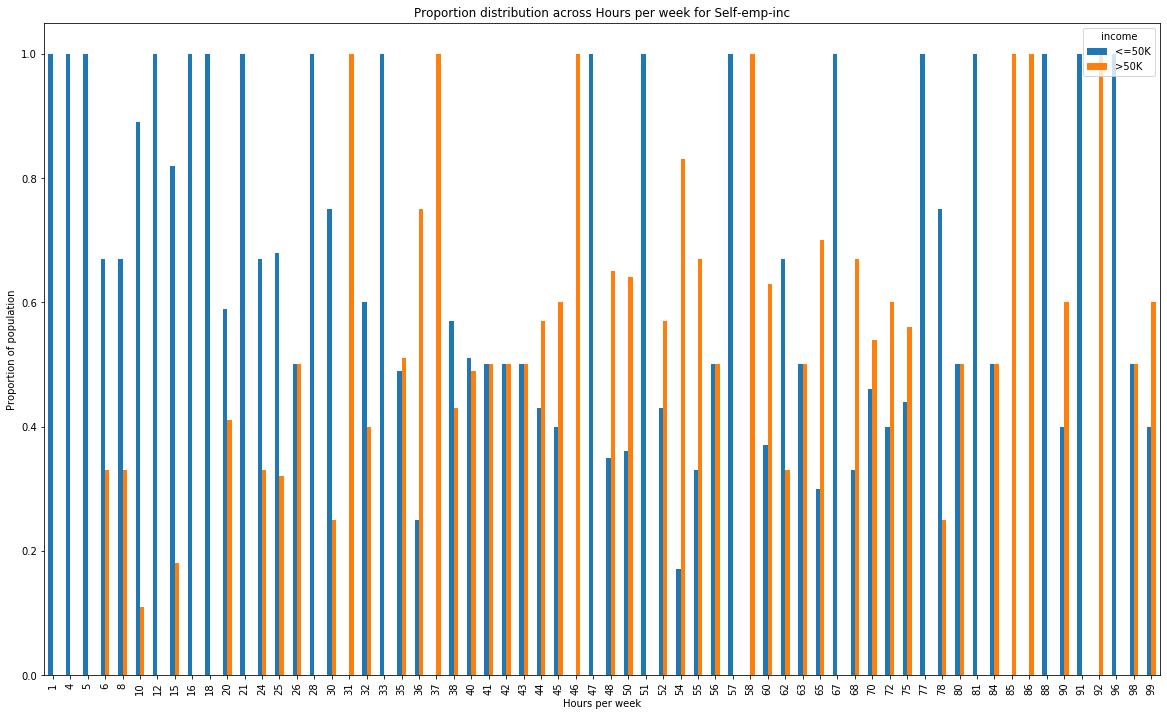

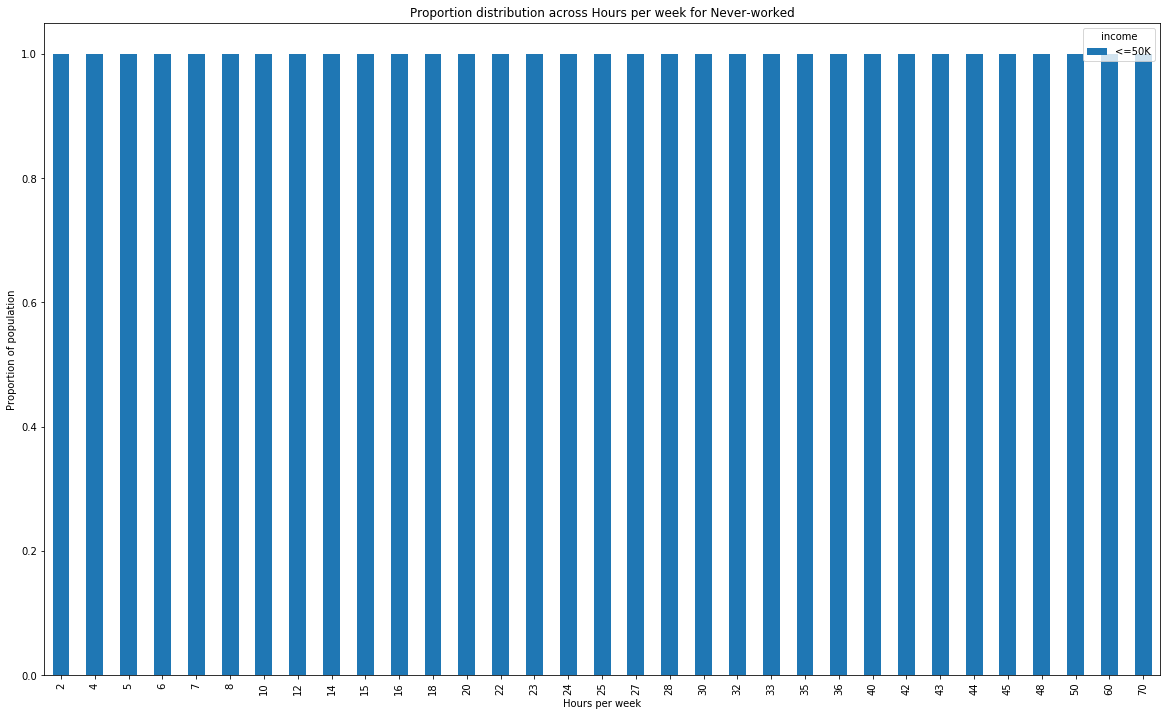

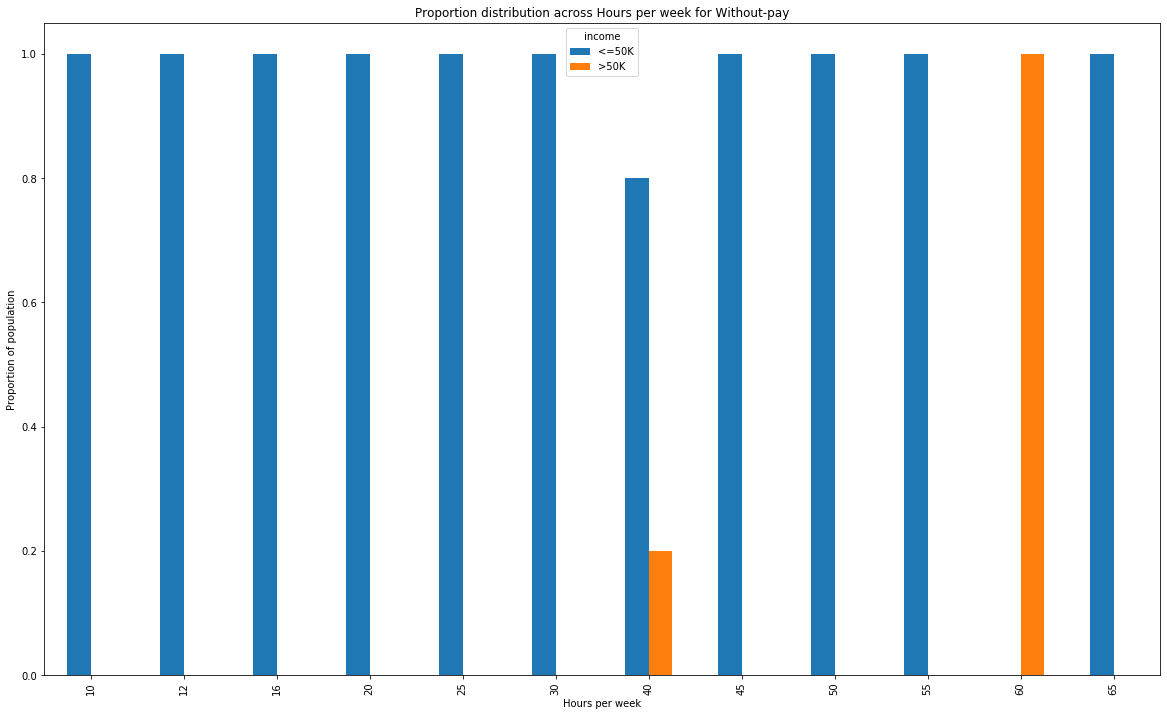

In [24]:
printmd('### 2.7.2 Hours worked across working classes')

for i in adult.workclass.unique():
    df = adult[adult.workclass == i]

    hours_per_week = round(pd.crosstab(df['hours-per-week'], df.income).div(pd.crosstab(df['hours-per-week'], df.income).apply(sum,1),0),2)
    # hours_per_week.sort_values(by = '>50K', inplace = True)
    ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week for '+ i, figsize = (20,12))
    ax.set_xlabel('Hours per week')
    ax.set_ylabel('Proportion of population')

    print()

---
# 3. Data Transformations

## 3.1. Feature Selection

In [25]:
# Remove education and fnlwgt
adult.drop(columns = ['education','fnlwgt','hours-per-week'], inplace = True)

printmd('* We have 2 features that convey the same meaning, \'education\' \
        and \'educational-num\'. To avoid the effect of this attribute on the models to be \
        overstated, I am not going to use the categorical education attribute.')
printmd('* I use the categorical Hours work column and drop the \'hour-per-week\' column')
printmd('* Also, I chose not to use the \'Fnlwgt\' attribute that is used by the census, \
        as the inverse of sampling fraction adjusted for non-response and over or under sampling \
        of particular groups. This attribute does not convey individual related meaning.')


* We have 2 features that convey the same meaning, 'education'         and 'educational-num'. To avoid the effect of this attribute on the models to be         overstated, I am not going to use the categorical education attribute.

* I use the categorical Hours work column and drop the 'hour-per-week' column

* Also, I chose not to use the 'Fnlwgt' attribute that is used by the census,         as the inverse of sampling fraction adjusted for non-response and over or under sampling         of particular groups. This attribute does not convey individual related meaning.

## 3.2 Normalization

## Box plot

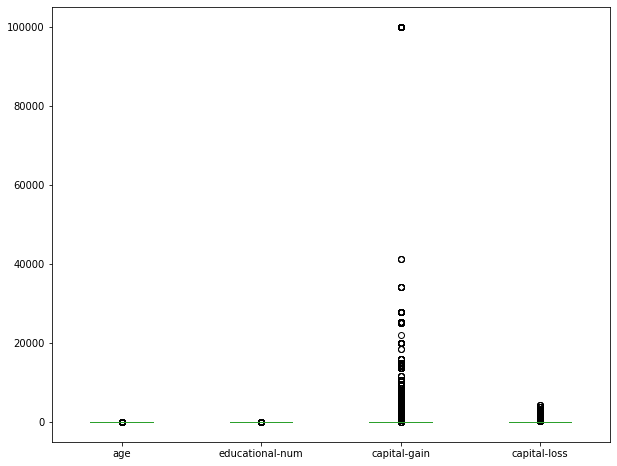

In [26]:
printmd('## Box plot')
adult.select_dtypes(exclude = 'category').plot(kind = 'box', figsize = (10,8))

Normalization happens on the training dataset, by removing the mean and \
        scaling to unit variance. These values are stored and then later applied  \
        to the test data before the test data is passed to the model for prediction. 

---
# 4. Model Development & Classification 

## 4.1. Data Preparation

One-hot encoding is the process of representing multi-class categorical features as binary features, one for each class. Although this process increases the dimensionality of the dataset, classification algorithms tend to work better on this format of data.

I use one-hot encoding to represent all the categorical features in the dataset. 


In [27]:
# Data Prep
adult_data = adult.drop(columns = ['income'])
adult_label = adult.income


adult_cat_1hot = pd.get_dummies(adult_data.select_dtypes('category'))
adult_non_cat = adult_data.select_dtypes(exclude = 'category')

adult_data_1hot = pd.concat([adult_non_cat, adult_cat_1hot], axis=1, join='inner')


In [28]:
# Train - Test split
train_data, test_data, train_label, test_label = train_test_split(adult_data_1hot, adult_label, test_size  = 0.25)

In [29]:
# Normalization
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# Fitting only on training data
scaler.fit(train_data)  
train_data = scaler.transform(train_data)  

# Applying same transformation to test data
test_data = scaler.transform(test_data) 

In [30]:
def model_eval(actual, pred):
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc['>50K','>50K']
    TN = confusion.loc['<=50K','<=50K']
    FP = confusion.loc['<=50K','>50K']
    FN = confusion.loc['>50K','<=50K']

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out


## 4.2. Model Development
### 4.2.1. Decision Tree

For the decision tree classifier, I experimented with the splitting criteria, minimum samples required to split, max depth of the tree, minimum samples required at the leaf level and the maximum features to consider when looking for the best split. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Splitting criteria:** Gini Index (Using Gini Index marginally outperformed Entropy with a higher accuracy.)
*	**Min samples required to split:** 5% (Best amongst 1%, 10% and 5%.)
*	**Max Depth:** None
*	**Min samples required at leaf:**  0.1 % (Best amongst 1%, 5% and 0.1%.)
*	**Max features:** number of features (Performs better than 'auto', 'log2' and 'sqrt'.)


In [31]:
# Gini 
clf_gini = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_split = 0.05, min_samples_leaf = 0.001, max_features = None)
clf_gini = clf_gini.fit(train_data, train_label)
clf_gini_pred = clf_gini.predict(test_data)
DTree_Gini = model_eval(test_label, clf_gini_pred)
print('Desicion Tree using Gini Index : %.2f percent.' % (round(DTree_Gini['accuracy']*100,2)))


# Entropy
clf_entropy = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 0.05, min_samples_leaf = 0.001)
clf_entropy = clf_entropy.fit(train_data, train_label)
clf_entropy_pred = clf_entropy.predict(test_data)
DTree_Entropy = model_eval(test_label, clf_entropy_pred)
print('Desicion Tree using Entropy : %.2f percent.' % (round(DTree_Entropy['accuracy']*100,2)))


printmd('### Model Evaulation ')
ovl_dtree = round(pd.DataFrame([DTree_Entropy, DTree_Gini], index = ['DTree_Entropy','DTree_Gini']),4)
display(ovl_dtree)

Desicion Tree using Gini Index : 84.68 percent.
Desicion Tree using Entropy : 84.64 percent.


### Model Evaulation 

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
DTree_Entropy,0.8464,0.7579,0.5483,0.6363,0.5483,0.9432,0.1536
DTree_Gini,0.8468,0.7559,0.5530,0.6387,0.5530,0.9421,0.1532


### 4.2.2. Artificial Neural Network
For the ANN classifier, I experimented with the activation function, the solver for weight optimization, regularization term and learning schedule for weight updates. The following values of the parameters attained the best accuracy during classification. Other parameters were neither applicable to the 'adam' solver nor did it improve the performance of the model. Results in the table below.

*	**Activation:** Logistic (Marginally outperformed 'relu', 'tanh' and 'identity' functions.)
*   **Solver:** Adam (Works well on relatively large datasets with thousands of training samples or more)
*   **Alpha:** 1e-4 (Best amongst 1, 1e-1, 1e-2, 1e-3, 1e-4 and 1e-5)
*   **Learning Rate:**  'invscaling' (Gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'.)


In [32]:
# Tan H
ann_tanh = MLPClassifier(activation = 'tanh', solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(10, 2), random_state=1, warm_start=True)
ann_tanh.fit(train_data, train_label)                         
ann_tanh_pred = ann_tanh.predict(test_data)
ANN_TanH = model_eval(test_label, ann_tanh_pred)
print('ANN using TanH and lbfgs solver : %.2f percent.' % (round(ANN_TanH['accuracy']*100,2)))


# Relu
ann_relu = MLPClassifier(activation = 'relu', solver='adam', alpha=1e-1, 
                    hidden_layer_sizes=(5, 2), random_state=1,
                    learning_rate  = 'invscaling',
                    warm_start = True)
ann_relu.fit(train_data, train_label)                         
ann_relu_pred = ann_relu.predict(test_data)
ANN_relu = model_eval(test_label, ann_relu_pred)
print('ANN using relu and adam solver : %.2f percent.' % (round(ANN_relu['accuracy']*100,2)))

# Log
ann_log = MLPClassifier(activation = 'logistic', solver='adam', 
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling', 
                    random_state=1, warm_start = True)
ann_log.fit(train_data, train_label)                         
ann_log_pred = ann_log.predict(test_data)
ANN_log = model_eval(test_label, ann_log_pred)
print('ANN using logistic and adam solver : %.2f percent.' % (round(ANN_log['accuracy']*100,2)))

# Identity
ann_identity = MLPClassifier(activation = 'identity', solver='adam', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=1, warm_start = True)
ann_identity.fit(train_data, train_label)                         
ann_identity_pred = ann_identity.predict(test_data)
ANN_identity = model_eval(test_label, ann_identity_pred)
print('ANN using identity and adam solver : %.2f percent.' % (round(ANN_identity['accuracy']*100,2)))

printmd('### Model Evaulation ')
ovl_ann = round(pd.DataFrame([ANN_TanH, ANN_relu, ANN_log, ANN_identity], index = ['ANN_TanH','ANN_relu', 'ANN_log', 'ANN_identity']),4)
display(ovl_ann)

ANN using TanH and lbfgs solver : 85.00 percent.
ANN using relu and adam solver : 85.09 percent.
ANN using logistic and adam solver : 85.27 percent.
ANN using identity and adam solver : 84.70 percent.


### Model Evaulation 

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
ANN_TanH,0.8500,0.7301,0.6148,0.6675,0.6148,0.9262,0.1500
ANN_relu,0.8509,0.7271,0.6262,0.6729,0.6262,0.9238,0.1491
ANN_log,0.8527,0.7435,0.6085,0.6692,0.6085,0.9319,0.1473
ANN_identity,0.8470,0.7382,0.5817,0.6507,0.5817,0.9331,0.1530


### 4.2.3. Support Vector Machine
For the SVM classifier, I experimented with the various available kernels, the penalty of the error term and the tolerance for stopping criteria. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Kernel:** rbf (Marginally outperformed 'linear, 'poly' and 'sigmoid' kernels.)
*	**C, penalty of the error term:** 1 (Best amongst 0.1, 0.5, 1 and 10)
*	**Tolerance for stopping criteria:** 1e-3 (Best amongst 1e-1, 1e-2, 1e-3, 1e-4 and 1e-5)


In [33]:
# rbf kernal
svm_clf_rbf = svm.SVC(kernel = 'rbf', C = 1, tol = 1e-3)
svm_clf_rbf.fit(train_data, train_label)
svm_clf_rbf_pred = svm_clf_rbf.predict(test_data)
SVM_rbf = model_eval(test_label, svm_clf_rbf_pred)
print('SVM using rbf kernel : %.2f percent.' % (round(SVM_rbf['accuracy']*100,2)))

# Linear kernel
svm_clf_linear = svm.SVC(kernel = 'linear')
svm_clf_linear.fit(train_data, train_label)
svm_clf_linear_pred = svm_clf_linear.predict(test_data)
SVM_linear = model_eval(test_label, svm_clf_linear_pred)
print('SVM using linear kernel : %.2f percent.' % (round(SVM_linear['accuracy']*100,2)))


# Poly kernal
svm_clf_poly = svm.SVC(kernel = 'poly')
svm_clf_poly.fit(train_data, train_label)
svm_clf_poly_pred = svm_clf_poly.predict(test_data)
SVM_poly = model_eval(test_label, svm_clf_poly_pred)
print('SVM using poly kernel : %.2f percent.' % (round(SVM_poly['accuracy']*100,2)))


svm_clf_sigmoid = svm.SVC(kernel = 'sigmoid')
svm_clf_sigmoid.fit(train_data, train_label)
svm_clf_sigmoid_pred = svm_clf_sigmoid.predict(test_data)
SVM_sigmoid = model_eval(test_label, svm_clf_sigmoid_pred)
print('SVM using sigmoid kernel : %.2f percent.' % (round(SVM_sigmoid['accuracy']*100,2)))



#printmd('### 3.3.2. Model Evaulation ')
ovl_svm = round(pd.DataFrame([SVM_rbf, SVM_linear, SVM_poly, SVM_sigmoid], index = ['SVM_rbf','SVM_linear', 'SVM_poly', 'SVM_sigmoid']),4)
display(ovl_svm)

SVM using rbf kernel : 84.74 percent.
SVM using linear kernel : 84.82 percent.
SVM using poly kernel : 83.03 percent.
SVM using sigmoid kernel : 80.51 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
SVM_rbf,0.8474,0.7449,0.5731,0.6478,0.5731,0.9363,0.1526
SVM_linear,0.8482,0.7414,0.5838,0.6532,0.5838,0.9339,0.1518
SVM_poly,0.8303,0.7185,0.5052,0.5932,0.5052,0.9358,0.1697
SVM_sigmoid,0.8051,0.6198,0.5286,0.5706,0.5286,0.8948,0.1949


### 4.2.4. Ensemble Models

### 4.2.4.1. Random Forest
For the random forests classifier, I experimented with the number of trees, splitting criteria, minimum samples required to split, max depth of the tree, minimum samples required at the leaf level and the maximum features to consider when looking for the best split. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Num estimators:** 100 (Best amongst 10, 50 and 100)
*	**Splitting criteria:** Gini Index (Using Gini Index marginally outperformed Entropy with a higher accuracy.)
*	**Min samples required to split:** 5% (Best amongst 1%, 10% and 5%.)
*	**Max Depth:** None
*	**Min samples required at leaf:**  0.1 % (Best amongst 1%, 5% and 0.1%.)
*	**Max features:** number of features (Performs better than 'auto', 'log2' and 'sqrt'.)


In [34]:
# Gini
r_forest_gini = RandomForestClassifier(n_estimators=100, criterion = 'gini', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
r_forest_gini.fit(train_data, train_label)
r_forest_gini_pred = r_forest_gini.predict(test_data)
rforest_gini = model_eval(test_label, r_forest_gini_pred)
print('Random Forest using Gini Index : %.2f percent.' % (round(rforest_gini['accuracy']*100,2)))

# Entropy
r_forest_entropy = RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
r_forest_entropy.fit(train_data, train_label)
r_forest_entropy_pred = r_forest_entropy.predict(test_data)
rforest_entropy = model_eval(test_label, r_forest_entropy_pred)
print('Random Forest using Entropy : %.2f percent.' % (round(rforest_entropy['accuracy']*100,2)))

#printmd('### 3.4.1.2. Model Evaulation ')
ovl_rf = round(pd.DataFrame([rforest_gini, rforest_entropy], index = ['rforest_gini','rforest_entropy']),4)
display(ovl_rf)

Random Forest using Gini Index : 85.02 percent.
Random Forest using Entropy : 85.16 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
rforest_gini,0.8502,0.7717,0.5517,0.6434,0.5517,0.9471,0.1498
rforest_entropy,0.8516,0.7764,0.5537,0.6464,0.5537,0.9483,0.1484


### 4.2.4.2. Adaboost
For the adaboost classifier, I experimented with base estimator from which the boosted ensemble is built and number of estimators. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Base Estimator:** DecisionTreeClassifier
*	**Num estimators:** 100 (Best amongst 10, 50 and 100.)


In [35]:
ada = AdaBoostClassifier(n_estimators=100)                     
ada.fit(train_data, train_label)
ada_pred = ada.predict(test_data)
adaboost = model_eval(test_label, ada_pred)
print('Adaboost : %.2f percent.' % (round(adaboost['accuracy']*100,2)))

#printmd('### 3.4.2.2. Model Evaulation ')
ovl_ada = round(pd.DataFrame([adaboost], index = ['adaboost']),4)
display(ovl_ada)

Adaboost : 86.29 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
adaboost,0.8629,0.7775,0.6169,0.6879,0.6169,0.9427,0.1371


### 4.2.5. Logistic Regression

In [36]:
log_reg = LogisticRegression(penalty = 'l2', dual = False, tol = 1e-4, fit_intercept = True, 
                            solver = 'liblinear')
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)
logistic_reg = model_eval(test_label, log_reg_pred)
print('Logistic Regression : %.2f percent.' % (round(logistic_reg['accuracy']*100,3)))

#printmd('### 3.5.2. Model Evaulation ')
ovl_logreg = round(pd.DataFrame([logistic_reg], index = ['logistic_reg']),4)
display(ovl_logreg)

Logistic Regression : 84.72 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
logistic_reg,0.8472,0.7353,0.5878,0.6533,0.5878,0.9313,0.1528


### 4.2.6. k Nearest Neighbours
For the K nearest neighbours classifier, I experimented with the num of neighbours values, every odd number ranging from 1 to 50.

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn_outs = []
for i in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_data, train_label) 
    knn_pred = knn.predict(test_data)
    knn_perf = model_eval(test_label, knn_pred)
    knn_perf['k'] = i
    knn_outs.append(knn_perf)

ovl_knn = round(pd.DataFrame(knn_outs),4)
display(ovl_knn)

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate,k
0,0.7929,0.5790,0.5660,0.5724,0.5660,0.8665,0.2071,1
1,0.8175,0.6437,0.5707,0.6050,0.5707,0.8975,0.1825,3
2,0.8246,0.6704,0.5583,0.6093,0.5583,0.9110,0.1754,5
3,0.8298,0.6849,0.5654,0.6194,0.5654,0.9156,0.1702,7
4,0.8299,0.6882,0.5587,0.6167,0.5587,0.9179,0.1701,9
5,0.8302,0.6903,0.5567,0.6163,0.5567,0.9190,0.1698,11
6,0.8307,0.6936,0.5533,0.6156,0.5533,0.9207,0.1693,13
7,0.8290,0.6891,0.5500,0.6118,0.5500,0.9195,0.1710,15
8,0.8315,0.6932,0.5597,0.6193,0.5597,0.9196,0.1685,17
9,0.8318,0.6973,0.5537,0.6172,0.5537,0.9220,0.1682,19


---
# 5. Model Evaluation
## 5.1. Overall Performance Statistics

In [38]:
overall_eval = pd.concat([ovl_dtree, ovl_ann, ovl_svm, ovl_rf, ovl_ada, ovl_logreg], axis = 0)
overall_eval.sort_values(by = ['f_measure', 'accuracy'], ascending = False, inplace = True)

printmd('Combing the performance statistics of all the model developed, as seen in table below, \
        we see that the ensemble model Adaboost hast the highest F-measure (0.6833), precision (0.7524) \
        and accuracy (0.8616). The Artificial neural network models are only marginally being in terms of \
        accuracy and F-measure. Almost all the model have an accuracy greater than 0.84, except for two SVM \
        models. The table below lists the accuracy, error rate, F-measure, precision, recall, sensitivity and \
        specificity of all the models developed.')

display(overall_eval)

Combing the performance statistics of all the model developed, as seen in table below,         we see that the ensemble model Adaboost hast the highest F-measure (0.6833), precision (0.7524)         and accuracy (0.8616). The Artificial neural network models are only marginally being in terms of         accuracy and F-measure. Almost all the model have an accuracy greater than 0.84, except for two SVM         models. The table below lists the accuracy, error rate, F-measure, precision, recall, sensitivity and         specificity of all the models developed.

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
adaboost,0.8629,0.7775,0.6169,0.6879,0.6169,0.9427,0.1371
ANN_relu,0.8509,0.7271,0.6262,0.6729,0.6262,0.9238,0.1491
ANN_log,0.8527,0.7435,0.6085,0.6692,0.6085,0.9319,0.1473
ANN_TanH,0.8500,0.7301,0.6148,0.6675,0.6148,0.9262,0.1500
logistic_reg,0.8472,0.7353,0.5878,0.6533,0.5878,0.9313,0.1528
SVM_linear,0.8482,0.7414,0.5838,0.6532,0.5838,0.9339,0.1518
ANN_identity,0.8470,0.7382,0.5817,0.6507,0.5817,0.9331,0.1530
SVM_rbf,0.8474,0.7449,0.5731,0.6478,0.5731,0.9363,0.1526
rforest_entropy,0.8516,0.7764,0.5537,0.6464,0.5537,0.9483,0.1484
rforest_gini,0.8502,0.7717,0.5517,0.6434,0.5517,0.9471,0.1498


## 5.2. ROC Curve

In [39]:
def generateRoc(test_data, test_label, classifiers, pred_labels, plot_labels, limiter):
    
    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    
    y_test = label_binarize(test_label, classes=['<=50K', '>50K'])
    plt.figure()
    
    for i in range(len(classifiers)):
        
        if plot_labels[i] not in limiter:
            continue
        
        y_score = classifiers[i].predict_proba(test_data)
        pos_class_index = list(np.unique(pred_labels[i])).index('>50K')
        
        fpr, tpr, thres = metrics.roc_curve(y_test.ravel(),y_score[:,pos_class_index], pos_label=1)
                               
        lw = 2
        plt.plot(fpr, tpr, color=color[i % len(color)],lw=lw, label=plot_labels[i])
        
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


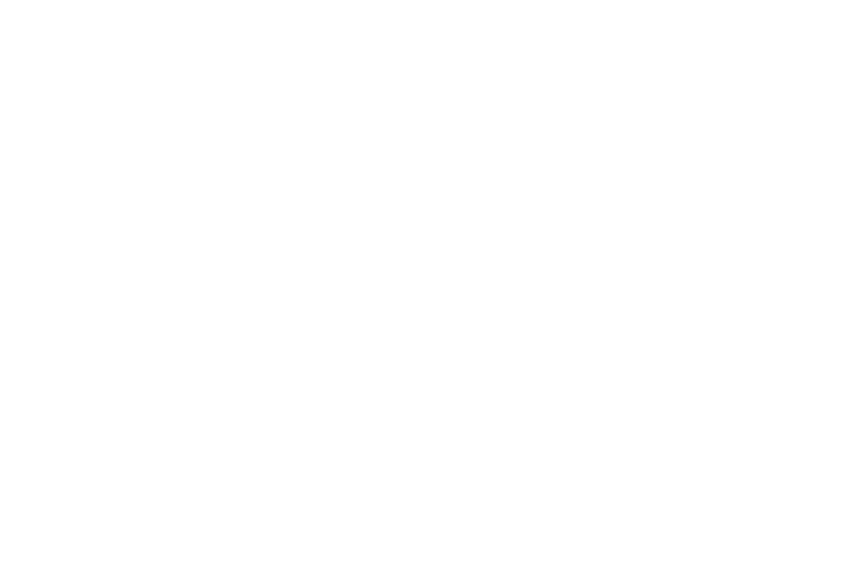

<IPython.core.display.Javascript object>


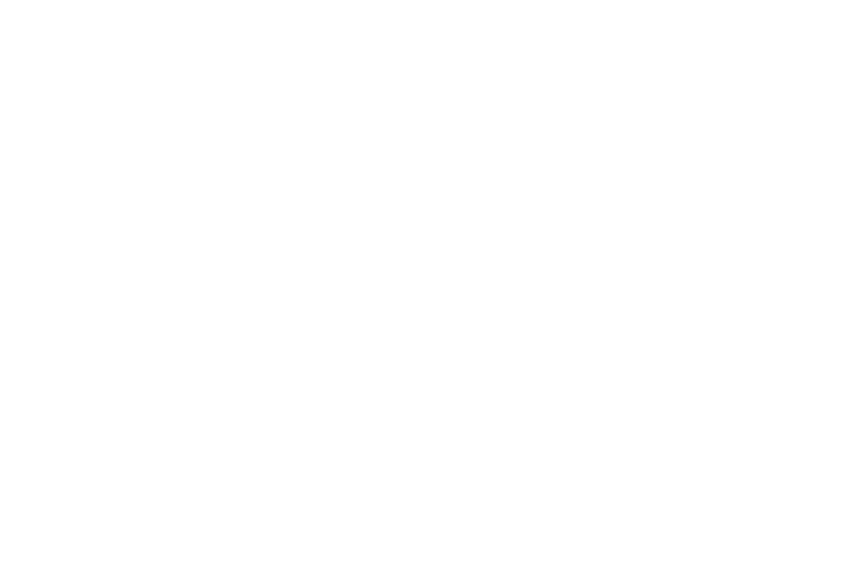

In [40]:
%matplotlib notebook
classifier_list = [clf_gini
                ,clf_entropy
                ,ann_tanh
                ,ann_relu
                ,ann_log
                ,ann_identity
#                 ,svm_clf_rbf
#                 ,svm_clf_linear
#                 ,svm_clf_poly
#                 ,svm_clf_sigmoid
                ,r_forest_gini
                ,r_forest_entropy
                ,ada
                ,log_reg
                ] 
pred_list = [clf_gini_pred
            ,clf_entropy_pred
            ,ann_tanh_pred
            ,ann_relu_pred
            ,ann_log_pred
            ,ann_identity_pred
#             ,svm_clf_rbf_pred
#             ,svm_clf_linear_pred
#             ,svm_clf_poly_pred
#             ,svm_clf_sigmoid_pred
            ,r_forest_gini_pred
            ,r_forest_entropy_pred
            ,ada_pred
            ,log_reg_pred
            ]

clf_labels = ['DTree Gini'
            ,'DTree Entropy'
            ,'ANN TanH'
            ,'ANN relu'
            ,'ANN Logistic'
            ,'ANN Identity'
#             ,svm_clf_rbf_pred
#             ,svm_clf_linear_pred
#             ,svm_clf_poly_pred
#             ,svm_clf_sigmoid_pred
            ,'RForest Gini'
            ,'RForest Entropy'
            ,'Adaboost'
            ,'Logistic Regression'
            ]

limiter = ['Adaboost', 'ANN TanH', 'ANN relu', 'ANN Logistic', 'Logistic Regression']
generateRoc(test_data, test_label, classifier_list, pred_list, clf_labels, limiter)

The plot above of the receiver operating characteristic curve for the top 5 models; Adaboost, ANN with logistics activation function, ANN with relu activation function, ANN with tanH activation function and logistic regression model. I chose to plot only the top 5 models as the ROC curves of most of the models overlap and the it is not easy to interpret the curve. 

From figure, we can see that the ROC curve of the Adaboost model has the highest lift and is closest to the top left corner (TPR of 1 and FPR of 0) of the plot. The Adaboost model's curve clearly separates itself from the ROC curves of the other 4 models, which overlap with each other. 

---
# 5. Conclusion

I choose **Adaboost** model as my preferred my approach. The Adaboost model not only has the **highest accuracy**, but also has the **highest precision and F-measure** of all the models developed as a part of this analysis. The advantages of using Adaboost over other models is that they are very simple to implement. Since they are made up of weak individual learners, they are less susceptible to overfitting. However, Adaboost is sensitive to noisy data and outliers. 
